# CIFAR-10 Classification Example

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. CIFAR-10 dataset is directly available in TensorFlow. This example shows how to train a simple CNN for classification.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dropout, Dense, GlobalMaxPooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import utils

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize colors
x_train, x_test = x_train/255.0, x_test/255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

# Find the number of classes
K = np.unique(y_train.flatten()).size

# Print input size and number of classes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"number of classes: {K}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
number of classes: 10


In [3]:
# Input
i = Input(shape=x_train[0].shape)

#--- Old Model ---
#x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
#x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
#x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

#--- New Model ---
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
#---------
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
#---------
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Fully connected layers
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

# Create the model
model = tf.keras.Model(i, x)

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496 

In [4]:
# Create the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Use image data generator for data augmentation
data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [0.9, 1.1],
    rotation_range = 10,
#    brightness_range = [0.9, 1.1],
    horizontal_flip = True
)

# Define batch size
batch_size = 256

# Define data generator and steps per training and validation
train_generator = data_generator.flow(x_train, y_train)
steps_per_epoch = x_train.shape[0] // batch_size
validation_steps = x_test.shape[0] // batch_size

# Fit the model
r = model.fit(
    train_generator,
    validation_data = (x_test, y_test), 
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs=40
)

Epoch 1/40
195/195 [==============================] - 7s 24ms/step - loss: 2.0991 - accuracy: 0.3186 - val_loss: 2.9594 - val_accuracy: 0.1093
Epoch 2/40
195/195 [==============================] - 4s 20ms/step - loss: 1.6543 - accuracy: 0.4017 - val_loss: 2.2508 - val_accuracy: 0.2640
Epoch 3/40
195/195 [==============================] - 4s 20ms/step - loss: 1.5296 - accuracy: 0.4529 - val_loss: 1.4585 - val_accuracy: 0.4724
Epoch 4/40
195/195 [==============================] - 4s 19ms/step - loss: 1.4366 - accuracy: 0.4795 - val_loss: 1.9463 - val_accuracy: 0.4225
Epoch 5/40
195/195 [==============================] - 4s 20ms/step - loss: 1.3439 - accuracy: 0.5248 - val_loss: 1.3886 - val_accuracy: 0.5015
Epoch 6/40
195/195 [==============================] - 4s 19ms/step - loss: 1.2766 - accuracy: 0.5479 - val_loss: 1.2384 - val_accuracy: 0.5564
Epoch 7/40
195/195 [==============================] - 4s 20ms/step - loss: 1.2252 - accuracy: 0.5643 - val_loss: 1.4043 - val_accuracy: 0.5356

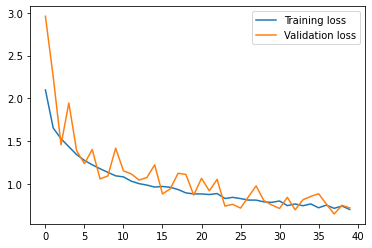

In [5]:
# Plot training- and cross-validation losses
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.legend()

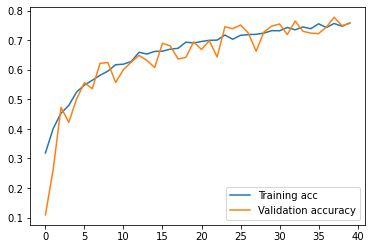

In [6]:
# Plot training- and cross-validation accuracy
plt.plot(r.history['accuracy'], label='Training acc')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()

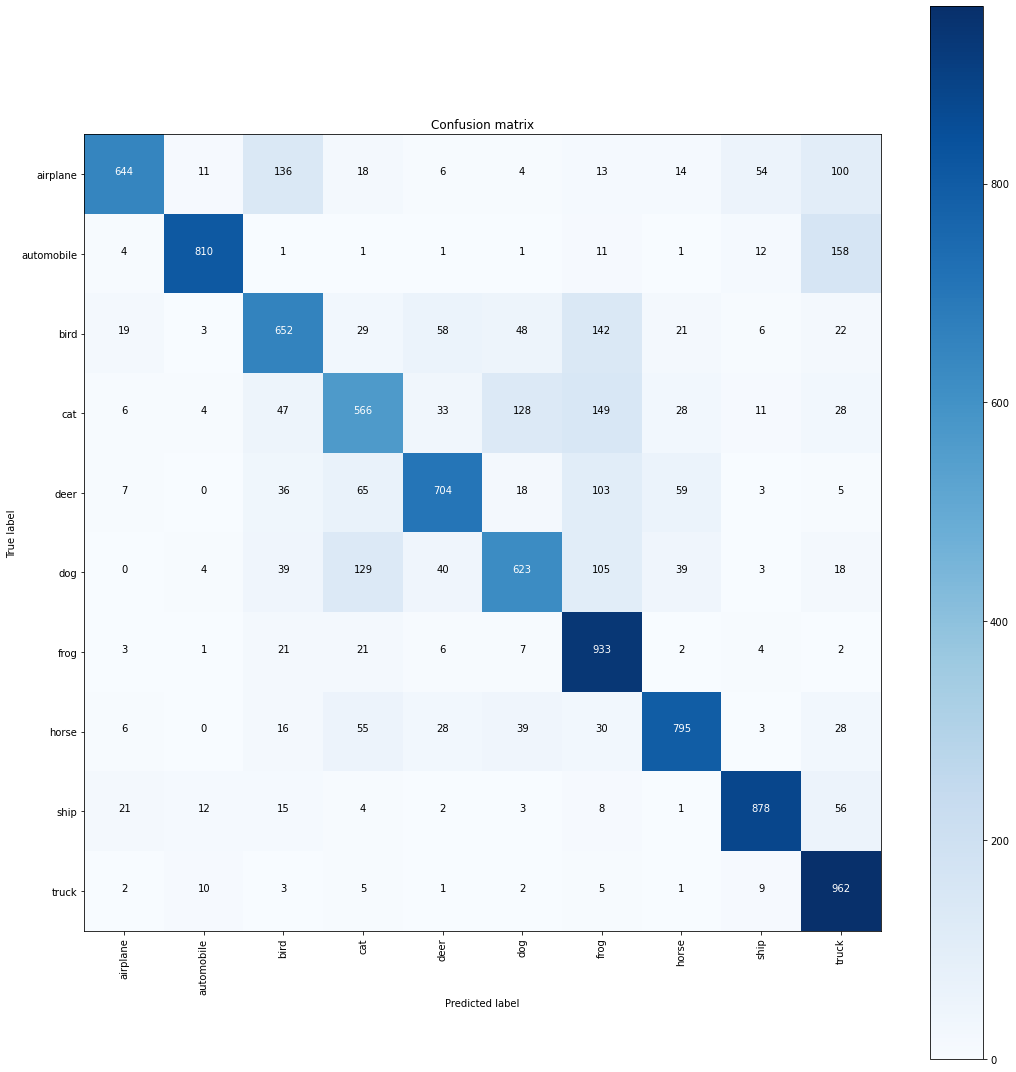

In [7]:
# Names corresponding to the classes
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

# Predict
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
utils.plot_confusion_matrix(cm, labels)

True label: 0
Classified label: 9


Text(0.5, 1.0, 'True label: airplane, classified label: truck')

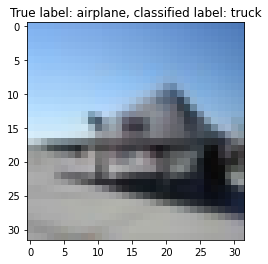

In [8]:
# Show examples of misclassified images with class names
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
print(f"True label: {y_test[i]}")
print(f"Classified label: {p_test[i]}")
plt.title("True label: %s, classified label: %s" % (labels[y_test.flatten()[i]], labels[p_test.flatten()[i]]))